<a href="https://colab.research.google.com/github/acanavera/DecissionSupportSystemforRetailDiscount/blob/main/DSSRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook implements the Exporatory Data Analysis and the Generalized Linear Model for a Decission Support System prototype

First step is import the data from link "https://www.kaggle.com/datasets/berkayalan/retail-sales-data?resource=download"
The sales.csv
The sales data set is too big to export it in github. After an Explortory data analisys, 4 represenative products are selected for the study and data for those product is stored in data.csv

In [13]:
!wget 'https://raw.githubusercontent.com/acanavera/DecissionSupportSystemforRetailDiscount/main/red_data.csv'

--2023-05-11 21:42:00--  https://raw.githubusercontent.com/acanavera/DecissionSupportSystemforRetailDiscount/main/red_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57962592 (55M) [text/plain]
Saving to: ‘red_data.csv’

red_data.csv        100%[===================>]  55.28M   196MB/s    in 0.3s    

2023-05-11 21:42:00 (196 MB/s) - ‘red_data.csv’ saved [57962592/57962592]



In [15]:
#import the file from 
import pandas as pd
all_data=pd.read_csv('red_data.csv')

<ipython-input-15-907ea74867ae>:3: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('red_data.csv')


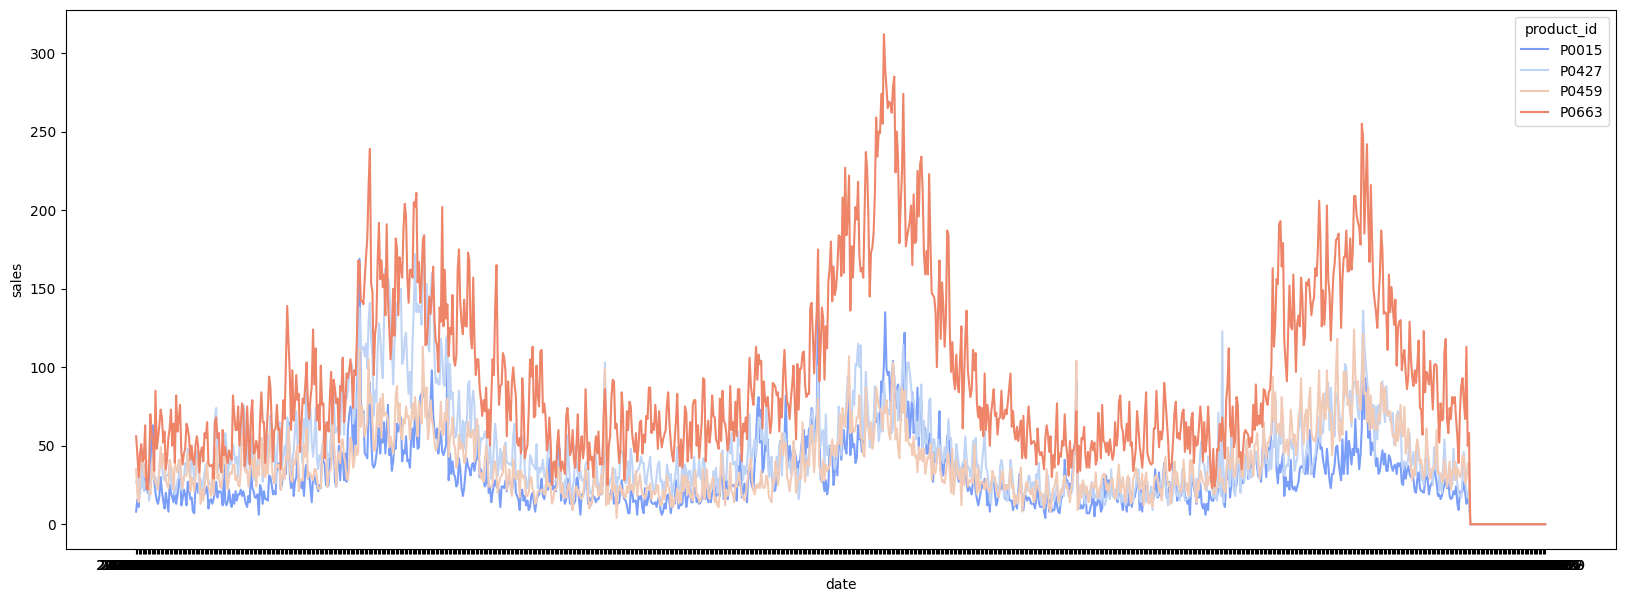

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
plt.figure(100, figsize=(20, 7))
sns.lineplot(x = "date", y = "sales", data=all_data[all_data['cluster_id']=='cluster_1'].groupby(['date','product_id'])['sales'].sum().reset_index(), hue='product_id',palette="coolwarm");


Feature Engineering: 

In [19]:
#We create a new featue for the store size
#cluster 1 seems a good candidate for optimization we need to calucalte the average sales per store
new=all_data[all_data['cluster_id']=='cluster_1'].groupby(['store_size'])['store_id'].nunique().reset_index().merge(all_data[all_data['cluster_id']=='cluster_1'].groupby(['store_size'])['sales'].sum().reset_index(),on ='store_size' )
new['avg_sales_per_store']=new['sales']/new['store_id']
store_size_bins=pd.cut(new['avg_sales_per_store'],bins=3, labels =['Small','Medium','Big'])
new['size_bins']=store_size_bins
newred=new[['store_size','size_bins']]

In [20]:
all_data=all_data.merge(newred,on='store_size')

In [22]:
#fill the prices that are missing with closest row
all_data['price']=all_data['price'].ffill()

In [23]:
#The column price and discount seem to be missing in many rows, we will create a new columns using the right formula
all_data['new_price']=all_data.apply(lambda row : row['revenue']/row['sales'] if row['sales'] != 0  else 0, axis=1)
all_data['new_discount']=all_data.apply(lambda row : row['price']- row['new_price'], axis=1)

In [25]:
#Need to set to 0 discounts that are negative or rows where sales is 0
all_data.loc[all_data['new_discount']<0,'new_discount']=0
all_data.loc[all_data['sales'] == 0,'new_discount']=0

In [29]:
all_data.drop(columns=['Unnamed: 0'],inplace=True)

In [30]:
all_data.columns

Index(['product_id', 'store_id', 'date', 'sales', 'revenue', 'stock', 'price',
       'promo_type_1', 'promo_bin_1', 'promo_type_2', 'promo_bin_2',
       'promo_discount_2', 'promo_discount_type_2', 'product_length',
       'product_depth', 'product_width', 'cluster_id', 'hierarchy1_id',
       'hierarchy2_id', 'hierarchy3_id', 'hierarchy4_id', 'hierarchy5_id',
       'storetype_id', 'store_size', 'city_id', 'size_bins', 'new_price',
       'new_discount'],
      dtype='object')

The variables identifying type of product and store have too many values. If we hot encode them as they are we will have may esparse features. We will create dummies and reduce some values if needed.

In [31]:
#create dummies for the right variables 
dummies_promo_type_1=pd.get_dummies(all_data['promo_type_1'],prefix='proty1_')
dummies_promo_type_2=pd.get_dummies(all_data['promo_type_2'],prefix='proty2_')
dummies_storetype_id=pd.get_dummies(all_data['storetype_id'],prefix='storetype_')
dummies_store_size=pd.get_dummies(all_data['size_bins'],prefix='storesize_')

In [34]:
#merge dummies with original
all_data=all_data.join(dummies_promo_type_1).join(dummies_promo_type_2).join(dummies_storetype_id).join(dummies_store_size)

In [71]:
#remove variables not needed for the model
all_data_model=all_data[['product_id', 'store_id', 'date', 'sales', 'revenue', 'stock', 'price','new_discount', 'proty1__PR03', 'proty1__PR05', 'proty1__PR06',
       'proty1__PR07', 'proty1__PR08', 'proty1__PR10', 'proty1__PR12',
       'proty1__PR14', 'proty1__PR17', 'proty1__PR18', 'proty2__PR02',
       'proty2__PR03', 'storetype__ST01', 'storetype__ST02', 'storetype__ST03',
       'storetype__ST04', 'storesize__Small',
       'storesize__Medium', 'storesize__Big']]


In [72]:
all_data_model['date']=pd.to_datetime(all_data_model['date'],infer_datetime_format=True)

<ipython-input-72-0f4b0a850093>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_model['date']=pd.to_datetime(all_data_model['date'],infer_datetime_format=True)


In [73]:
#add calendar variables
import datetime
import holidays
holidayst=holidays.Turkey()
all_data_model['weekday']=all_data_model['date'].dt.weekday
all_data_model['month']=all_data_model['date'].dt.month
all_data_model['holicday']=all_data_model['date'].apply(lambda x: holidayst.get(x))


<ipython-input-73-425c425951bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_model['weekday']=all_data_model['date'].dt.weekday
<ipython-input-73-425c425951bf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_model['month']=all_data_model['date'].dt.month
<ipython-input-73-425c425951bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [74]:
#create dummies with the dates
dummies_week_day=pd.get_dummies(all_data_model['weekday'],prefix='weekday')
dummies_month=pd.get_dummies(all_data_model['month'],prefix='month')
all_data_model=all_data_model.join(dummies_week_day).join(dummies_month)

In [75]:
#create dummies with hollidays
dummies_holiday=pd.get_dummies(all_data_model['holicday'],prefix='holiday')
all_data_model=all_data_model.join(dummies_holiday)

In [76]:
#Drop columns that are not useful for modeling
all_data_model.drop(columns=['weekday', 'month', 'holicday'],inplace=True)

Outlier Analysis

In [77]:
#Now before doing the correlations let's see if we see outliers that are not justified by any special offer/holiday
Q1 = all_data_model['sales'].quantile(0.25)
Q3 = all_data_model['sales'].quantile(0.96)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [78]:
outliers=all_data_model[all_data_model['sales']>upper_bound]

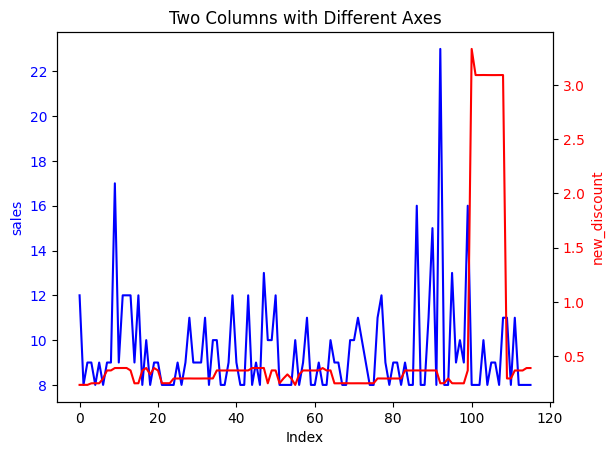

In [79]:
#print discounts against sales to see if higher discounts justify outliers
df=outliers[outliers['product_id']=='P0459'].copy()
df=df.reset_index()
fig, ax1 = plt.subplots()

# Plot the first column with the primary y-axis
ax1.plot(df.index, df['sales'], color='blue', label='A')
ax1.set_xlabel('Index')
ax1.set_ylabel('sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis with the primary y-axis
ax2 = ax1.twinx()

# Plot the second column with the secondary y-axis
ax2.plot(df.index, df['new_discount'], color='red', label='B')
ax2.set_ylabel('new_discount', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title for the chart
plt.title('Two Columns with Different Axes')

# Display the chart
plt.show()

Two conclusion about the analysis of outliers
- We need to remove tehe sales that are bigger than 35 as thre is not justification 
- We also need to limit the discount to one

In [80]:
#limit the discount to one.
all_data_model.loc[all_data_model['new_discount']>1,'new_discount']=1

In [81]:
#Limit the sales that are bigger than 35 as there is no justification for them
all_data_model.loc[all_data_model['sales']> 35,'sales']=35

In [82]:
#Finally we will create dummies for product
dummies_product=pd.get_dummies(all_data_model['product_id'],prefix='product')
all_data_model=all_data_model.join(dummies_product)

Let's start with modeling

In [83]:
#Ok now we are ready to model
import statsmodels.api as sm

In [84]:
#Split data between train and test

test=all_data_model.loc[all_data_model['date']>pd.Timestamp('2019-08-31')]
train=all_data_model.loc[all_data_model['date']<=pd.Timestamp('2019-08-31')]

In [85]:
#add a constant to the DataFrame to account for the intercept
train['const']=1

<ipython-input-85-b6ea889d12b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['const']=1


In [88]:
X=train[['const','price','new_discount', 'proty1__PR03', 'proty1__PR05', 'proty1__PR06',
       'proty1__PR07', 'proty1__PR08', 'proty1__PR10', 'proty1__PR12',
       'proty1__PR14', 'proty1__PR17', 'proty1__PR18', 'proty2__PR02',
       'proty2__PR03', 'storetype__ST01', 'storetype__ST02', 'storetype__ST03',
       'storetype__ST04', 'storesize__Small', 'storesize__Medium',
       'storesize__Big', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12',
       'holiday_Commemoration of Ataturk, Youth and Sports Day',
       'holiday_Democracy and National Unity Day', 'holiday_Labour Day',
       'holiday_National Sovereignty and Children\'s Day',
       'holiday_New Year\'s Day', 'holiday_Ramadan Feast',
       'holiday_Ramadan Feast Holiday', 'holiday_Republic Day',
       'holiday_Sacrifice Feast', 'holiday_Sacrifice Feast Holiday',
       'holiday_Victory Day','product_P0015','product_P0427','product_P0459','product_P0663']]

In [89]:
train['product_id'].unique()

array(['P0015', 'P0427', 'P0459', 'P0663'], dtype=object)

In [90]:
y=train['sales']

In [91]:
# Fit a GLM (with a Gaussian family and identity link function, which is equivalent to a linear regression)
glm = sm.GLM(y, X, family=sm.families.Gaussian(link=sm.families.links.identity()))
glm_results = glm.fit()

# Print the GLM summary
print(glm_results.summary())

# Calculate the predicted values (forecasts)
y_pred = glm_results.predict(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sales   No. Observations:               363938
Model:                            GLM   Df Residuals:                   363889
Model Family:                Gaussian   Df Model:                           48
Link Function:               identity   Scale:                         0.96920
Method:                          IRLS   Log-Likelihood:            -5.1069e+05
Date:                Fri, 12 May 2023   Deviance:                   3.5268e+05
Time:                        00:32:52   Pearson chi2:                 3.53e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5024
Covariance Type:            nonrobust                                         
                                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------